---
title: "Learning Pyro for Better Content Sorting"
author: "Daniel Geiszler"
date: "2024-12-15"
categories: [machine learning, python]
---
---


I've been looking for a reason to learn to use the Pyro library in Python for Markov Chain Monte Carlo (MCMC) simulations, and I've finally found one. This is me documenting how to learn to use it for future reference, and hopefully you'll be able to get something out of it too.

Have you ever sorted content on a website by "Top Ranked" or something similar, only do be inundated with a bunch of posts with a 100% rating but only a tiny number of reviews? It can make it frustrating or impossible to find "the best" of something when it's hiding below hundreds or thousands of other things. If you're going to rank by the average score for a piece of content, it's inevitable that you'll end up with some items near the top of the list that shouldn't be. This happens because low sample sizes (e.g., a small number of reviews or upvotes) lead to a wide variety of estimates of the content's "true" rating.

Thankfully, lots of smart companies have come up with better ways to rank their content! Reddit, for example, used to use [a confidence interval around the score of the of a post](https://github.com/reddit-archive/reddit/blob/master/r2/r2/lib/db/_sorts.pyx#L41) (see the cpdef double \_confidence function) to account for uncertainty in its "true" score. This has the effect of penalizing upvoted posts that have a low score with only a handful of upvotes, but it will also boost downvoted posts in the same situation. As the number of votes increases, the confidence in the post's true rating also increases. 

Other companies seem to have an issue with this. For example, Google Maps has pretty limited options on what you can sort by, and instead only allows you to [filter based on certain ranges of average review score](https://stackoverflow.com/questions/50070220/sorting-google-maps-places-by-number-of-reviews). This still leaves the top results polluted by new, fake, or closed restaurants when you're going out to eat. This isn't a good system, and I frequently find myself with bad results. You have to go to an [entirely different website](https://www.top-rated.online/) to get decent results.

Finding a better estimate of a restaurant's "true rating" is a good use case for Pyro, a probabilistic programming language thats uses PyTorch. Pyro make it easy to find a restaurant's "true rating" (posterior probability) given its current ratings (likelihood) and some assumptions about what its true rating is likely to be before any reviews are given (prior probability). These problems can be solved using MCMC simulations to estimate the posterior probability. PyTorch is supposed to make these sorts of problems easy, so I'm going to use it to estimate the posterior probabilities of some content and learn how to use Pyro along the way.

Installing PyTorch isn't as simple as most other python packages, so I recommend looking at their website to do it (https://pytorch.org/). Beyond that, you'll also need pandas and the pyro package (https://pyro.ai/).

In [1]:
# import packages

import torch
import pyro
import pyro.distributions as dist
import pandas as pd

from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO
from pyro.optim import Adam

If you installed PyTorch correctly and you have an nVidia GPU, you can run this to see if your GPU is available for PyTorch to use. This workbook should still work even if this isn't true, instead running the simulations on your CPU. The first few will run on the default device, but I'll switch to my GPU later.

In [2]:
if torch.cuda.is_available():
    print("CUDA is available. GPU is ready to be used.")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available. GPU is ready to be used.


As a toy example, let's consider a restaurant or some other piece of content that has a single upvote in an upvote/downvote rating system. This will run on the default device regardless of your GPU setup.

In [3]:
# Data: 1 thumb up out of 1 observation
data = torch.tensor([1.])

We first need to define a model that PyTorch will simulate. 

* The pyro.sample function here is given two arguments: the name of your sample and the prior distribution. In this case, we use the Beta(1,1) distribution as our prior. This draws a sample from the Beta(1,1) distribution for our prior. The beta distribution is a common prior when estimating probabilities because of both the posterior and the prior are defined over \[0,1\]. It is also a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) for the Binomial distribution, which is the distribution for a series of up-down votes. The Beta(1,1) is a uniform distribution, which indicates we have no information about the prior probability. In practice, Betas tend to be used more than Uniforms due to their flexibility, but the results should be the same regardless. It is also easy to interpret in our case because the Beta(a,b) parameters a and b correspond to pseudocounts for upvotes and downvotes for our content. This will come in handy later.

* The pyro.plate function indicates that all of the observations are IID, and again takes two arguments: a name and the number of observations. We then use the pyro.sample function again, but this time the probability of success (in this case, an upvoted restaurants) is given by the the probability from the first step, and our observed data is used as our evidence.

In [4]:
# Define the model
def beta_model(data):
    # Prior distribution for the probability of a thumb up
    prob_thumb_up = pyro.sample("prob_thumb_up", dist.Beta(1, 1))
    # Observing the data
    with pyro.plate("data", len(data)):
        pyro.sample("obs", dist.Bernoulli(prob_thumb_up), obs=data)

To simulate our posterior, we use NUTS ([No U-turn Sampler](https://stats.stackexchange.com/questions/311813/can-somebody-explain-to-me-nuts-in-english)). We then run our MCMC method to extract all of the posterior simulations. The NUTS sampler starts off slow and not giving useful information at the beginning, so we throw out the first warmup_steps.

In [5]:
# Run sampling
nuts_kernel = NUTS(beta_model)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=200)
mcmc.run(data)

Sample: 100%|██████████| 300/300 [00:00, 315.72it/s, step size=1.05e+00, acc. prob=0.872]


Now that our 100 samples have run in ~1 second, we can see what our posterior distribution looks like.

{'prob_thumb_up': tensor([0.9948, 0.9911, 0.9932, 0.8157, 0.9069, 0.9725, 0.9605, 0.7183, 0.6688,
        0.4664, 0.4664, 0.1412, 0.4164, 0.4164, 0.4718, 0.4669, 0.1655, 0.1651,
        0.9353, 0.9179, 0.9453, 0.6563, 0.9291, 0.9523, 0.9919, 0.9892, 0.8332,
        0.8525, 0.7400, 0.7400, 0.8004, 0.8386, 0.8639, 0.8639, 0.8468, 0.9864,
        0.7228, 0.2010, 0.8474, 0.6574, 0.6523, 0.6671, 0.6671, 0.7251, 0.8520,
        0.8915, 0.2909, 0.4525, 0.2638, 0.4680, 0.5942, 0.3475, 0.3475, 0.8394,
        0.8396, 0.7719, 0.7719, 0.3881, 0.3250, 0.5279, 0.6887, 0.0769, 0.9948,
        0.9938, 0.9592, 0.9085, 0.1504, 0.9345, 0.5709, 0.4091, 0.6242, 0.9275,
        0.1048, 0.9889, 0.9549, 0.9138, 0.7142, 0.7142, 0.8877, 0.8169, 0.8869,
        0.7573, 0.7573, 0.8330, 0.7542, 0.8275, 0.6461, 0.6482, 0.6646, 0.6646,
        0.5550, 0.5550, 0.7538, 0.5528, 0.1494, 0.4221, 0.8125, 0.7165, 0.3323,
        0.6686])}


array([[<Axes: title={'center': 'prob_thumb_up'}>]], dtype=object)

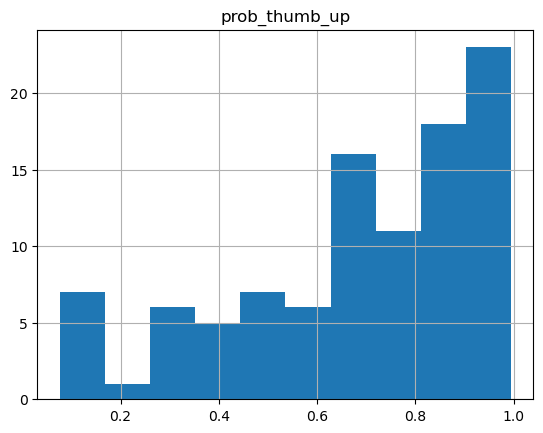

In [6]:
# Extract samples
samples = mcmc.get_samples()
prob_thumb_up_samples = samples['prob_thumb_up']
print(samples)

# Make histogram of samples
samples_df = pd.DataFrame(samples)
samples_df.hist()

Our probability distribution looks like it's multimodal, when it should be unimodal. That probably means the model didn't converge. Let's try upping the number of samples we use to see if we can get a better behaved distribution.

Sample: 100%|██████████| 10200/10200 [00:28, 357.90it/s, step size=6.56e-01, acc. prob=0.898]

{'prob_thumb_up': tensor([0.5870, 0.4914, 0.8957,  ..., 0.2461, 0.5114, 0.9622])}


array([[<Axes: title={'center': 'prob_thumb_up'}>]], dtype=object)

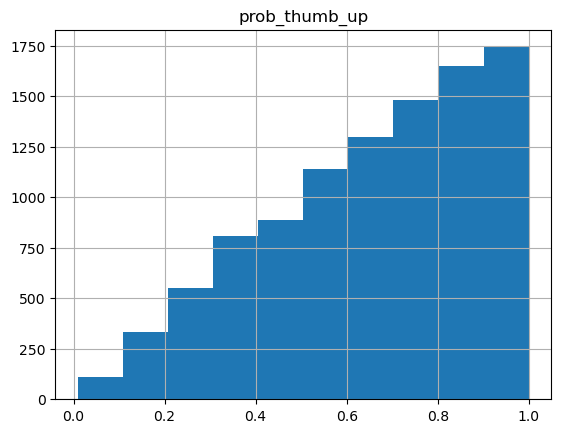

In [7]:
# Run sampling
nuts_kernel = NUTS(beta_model)
mcmc = MCMC(nuts_kernel, num_samples=10000, warmup_steps=200)
mcmc.run(data)

# Extract samples
samples = mcmc.get_samples()
prob_thumb_up_samples = samples['prob_thumb_up']
print(samples)

# Make histogram of samples
samples_df = pd.DataFrame(samples)
samples_df.hist()

This distribution looks much more regular. From this, we can calculate the confidence interval for our restaurant's "true rating".

In [8]:
# Compute confidence interval
confidence_interval = torch.quantile(prob_thumb_up_samples, torch.tensor([0.025, 0.975]))

print(f"Estimated probability of thumb up: {prob_thumb_up_samples.mean().item():.4f}")
print(f"95% confidence interval: {confidence_interval.tolist()}")

Estimated probability of thumb up: 0.6559
95% confidence interval: [0.1598558872938156, 0.9852998852729797]


We should also probably check to make sure that our estimates are valid. This particular example is trivial because of our choice of distribution and prior. Because we used a conjugate prior (Beta) for our observed data (Binomial/Bernoulli), we have a closed form solution for our expected result. I mentioned before that the a and b parameters for the Beta(a,b) distribution are pseudocounts for successes (thumbs up) and failures (thumbs down), respectively. That means that if our prior distribution has the form Beta(1,1) and we have observed 1 additional success, our posterior distribution has the form Beta(2,1).

You can see slide 12 of David Maracek's excellent [lecture on Beta-Bernoulli distributions](https://ufal.mff.cuni.cz/~marecek/npfl097/02_beta_bernoulli.pdf) to see what this looks like, or you can draw the Beta(2,1) distribution yourself using [this applet](https://mathlets.org/mathlets/beta-distribution/).

The shape of our simulated posterior looks almost exactly like our expected output. Success!

How a content rating system wants to use this information would be up to them. In Reddit's case, it looks like they used an 80%  bound to rank their posts. If you want your ranking to be much stricter, you could use the lower bound of the credible interval, which would push new entries to the bottom of the ranking. You could also increase the number of pseudocounts in your Beta prior to something like the mean value of upvotes and downvotes, which may be more appropriate if you want new content to be ranked "average" until proven otherwise.

In some cases, it may be more appropriate to do this in a regression framework so that you can control for other variables. I'm going to repeat this analysis using logistic regression, which models the log-odds of a success. I'll also do it on the GPU (although for small samples and simple models this may not be necessary due to the overhead incurred by moving data to your GPU).

First we'll check to see if we can use our GPU. If we can, we'll create our data on our GPU. All of the data needs to be in one place for this to work and it will default to your CPU, so you'll need to explicitly put everything on your GPU. A GPU will actually be a bit slower for this use case due to the overhead incurred, but it's a good reference for larger models.

In [10]:
# Check for CUDA availability and prepare data
if torch.cuda.is_available():
    device = torch.device("cuda")
    # Create data tensor on GPU
    data = torch.tensor([1.]).to(device)
    print("Data moved to GPU.")
else:
    device = torch.device("cpu")
    data = torch.tensor([1.]).to(device)
    print("CUDA not available, running on CPU.")
    
# Validate devices
torch.cuda.get_device_name(torch.cuda.current_device())

Data moved to GPU.


'NVIDIA GeForce RTX 3050 Laptop GPU'

Next we'll define our model. This model is going to look different from the previous one. In our logistic regression, the intercept will give us the log-odds of our restaurant's true probability of thumbs up. This parameter is no longer bounded on \[0,1\], which means the Beta distribution is no longer appropriate. There are a few options here. 
* A normal distribution with mean 0 (p = 0.5 means the odds are (0.5) / (1 - 0.5) = 1, and log(1) = 0. This is a common choice, but choosing the variance is tricky because there is no closed form solution, so we would have to pick one based on how informative we want it to be.
* A Cauchy distribution with mean 0 (for the same reason) and scale 2.5. This is based on the recommendation of Gelman et al (2008) (http://www.stat.columbia.edu/~gelman/research/published/priors11.pdf). There is still no way to properly estimate the variance of the intercept, so our choice is again going to affect our outcomes.

In [11]:
def logistic_model(data):  
    # Create parameters for the distribution on the correct device
    mean = torch.tensor(0., device=device)  # Ensure mean is a tensor on GPU
    scale = torch.tensor(2.5, device=device)  # Ensure standard deviation is a tensor on GPU
    
    # Create the Cauchy distribution with parameters on the correct device
    prior_dist = dist.Cauchy(mean, scale)
    
    # Sample intercept from the distribution
    intercept = pyro.sample("intercept", prior_dist)
    
    # Observing the data with Bernoulli likelihood
    with pyro.plate("data_plate", len(data)):
        pyro.sample("obs", dist.Bernoulli(logits=intercept), obs=data)

Then we repeat our sampling. I repeated this a few times before settling on 2000 samples for decent convergence.

In [12]:
#NUTS sampler
nuts_kernel = NUTS(logistic_model)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=200)
mcmc.run(data)

Sample: 100%|██████████| 2200/2200 [00:40, 54.64it/s, step size=1.72e-01, acc. prob=0.923] 


And again check our model convergence. To plot these, we'll also need to transfer these back to our CPU. We expect a normal distribution for the intercept parameter if the model converged. There are better ways to check the convergence such as Effective Sample Size (ESS) or Gelman-Rubin convergence, but they require running multiple chains which is finnicky on Windows.

array([[<Axes: title={'center': 'intercept'}>]], dtype=object)

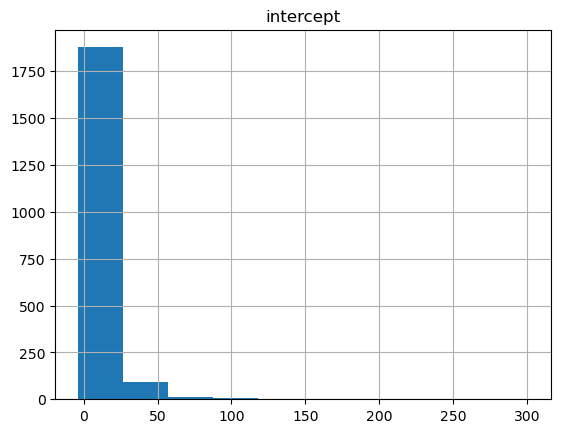

In [13]:
# Check model convergence
intercept_df = pd.DataFrame({'intercept' : mcmc.get_samples()['intercept'].to('cpu')})
intercept_df.hist()

That doesn't look very normal! Probably because we only have one sample. It's possible that a distribution with smaller tails, like the normal, will work better here. Let's try again with the normal distribution.

In [14]:
def logistic_model(data):  
    # Create parameters for the distribution on the correct device
    mean = torch.tensor(0., device=device)  # Ensure mean is a tensor on GPU
    scale = torch.tensor(2.5, device=device)  # Ensure standard deviation is a tensor on GPU
    
    # Create the Normal distribution with parameters on the correct device
    prior_dist = dist.Normal(mean, scale)
    
    # Sample intercept from the distribution
    intercept = pyro.sample("intercept", prior_dist)
    
    # Observing the data with Bernoulli likelihood
    with pyro.plate("data_plate", len(data)):
        pyro.sample("obs", dist.Bernoulli(logits=intercept), obs=data)

In [15]:
#NUTS sampler
nuts_kernel = NUTS(logistic_model)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=200)
mcmc.run(data)

Sample: 100%|██████████| 2200/2200 [00:19, 112.19it/s, step size=1.21e+00, acc. prob=0.923]


array([[<Axes: title={'center': 'intercept'}>]], dtype=object)

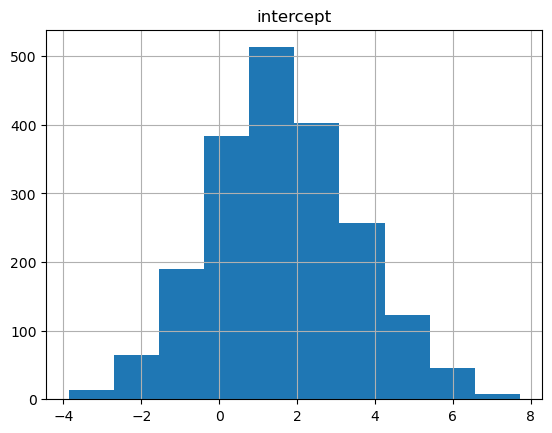

In [16]:
# Check model convergence
intercept_df = pd.DataFrame({'intercept' : mcmc.get_samples()['intercept'].to('cpu')})
intercept_df.hist()

That looks pretty normal now. We'll need to turn these back into probabilities using the signmoid function.

Inferred probability of a thumb up: 0.7413
95% confidence interval: [0.1398516297340393, 0.9961099028587341]


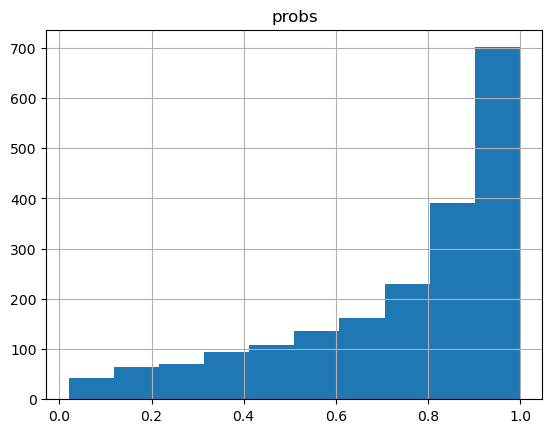

In [17]:
# Extract samples
samples = mcmc.get_samples()['intercept'].to('cpu')

# Plot probabilities
inferred_probs_df = pd.DataFrame({'probs' : torch.sigmoid(samples)})
inferred_probs_df.hist()


inferred_prob = torch.sigmoid(samples).mean().item()

print(f"Inferred probability of a thumb up: {inferred_prob:.4f}")

# Compute confidence interval
confidence_interval_vals = torch.quantile(samples, torch.tensor([0.025, 0.975]))
confidence_interval = torch.sigmoid(confidence_interval_vals)
print(f"95% confidence interval: {confidence_interval.tolist()}")

Our original estimate using the beta distribution was 0.6649 with a 95% confidence interval: \[0.1617867797613144, 0.9869610667228699\]. That's a bit different from this, but the choice of prior influences the outcome. Overall though, that looks like a pretty good estimate of the analytical solution despite only having a single sample.

What happens if we increased the number of samples to 100? How accurate can we get with a moderate amount of data? Let's say we want to model something with a 90% upvote rate, so 90 thumbs up and 10 thumbs down.

Sample: 100%|██████████| 2200/2200 [00:06, 358.01it/s, step size=1.25e+00, acc. prob=0.899]


Estimated probability of thumb up: 0.8920
95% confidence interval: [0.8236452341079712, 0.9434589743614197]


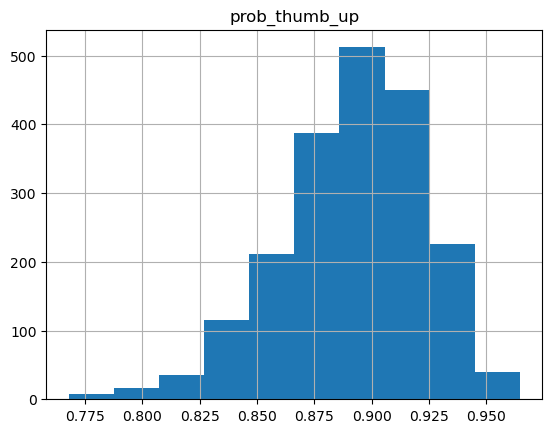

In [18]:
# Data: 90 thumbs up, 10 thumbs down
data = torch.cat((torch.ones(90), torch.zeros(10)))

# Rerun model with reduced steps
nuts_kernel = NUTS(beta_model)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=200)
mcmc.run(data)

# Extract samples
samples = mcmc.get_samples()
prob_thumb_up_samples = samples['prob_thumb_up']

# Make histogram of samples
samples_df = pd.DataFrame(samples)
samples_df.hist()

# Compute confidence interval
confidence_interval = torch.quantile(prob_thumb_up_samples, torch.tensor([0.025, 0.975]))

print(f"Estimated probability of thumb up: {prob_thumb_up_samples.mean().item():.4f}")
print(f"95% confidence interval: {confidence_interval.tolist()}")

An estimate of 0.89 for a 90% upvoted piece of content is pretty good, and the spread on the estimate is much tighter than before.

This is still a really simple model, though. For more complicated models, MCMC might be prohibitively slow. For real life scenarios, it's inlikely to be doing something with this few samples and this simple of a model. In these cases, you might want to try variational inference (VI) instead of MCMC. VI allows you to turn the sampling problem into an optimization problem, where you optimize the parameters of a distirbution directly. Here I'm going to use the Adam optimizer, which is short for adaptive gradient descent. It's popular in lots of mcahine learning applications due to its speed and ability to handle sparse gradients. We can check to see how well Adam is optimizing by checking to see if the evidence lower bound (ELBO) converges. We can pump up our data a bit, too.

Step 0 - Loss: 641.3312163352966
Step 1000 - Loss: 543.6905220746994
Step 2000 - Loss: 568.6181250810623
Step 3000 - Loss: 474.34459149837494
Step 4000 - Loss: 342.52564430236816
Step 5000 - Loss: 355.2464487552643
Step 6000 - Loss: 343.4673839211464
Step 7000 - Loss: 339.71015548706055
Step 8000 - Loss: 327.89236748218536
Step 9000 - Loss: 330.6277858018875
Posterior Mean: 2.189785957336426, Posterior Std: 0.15260715782642365


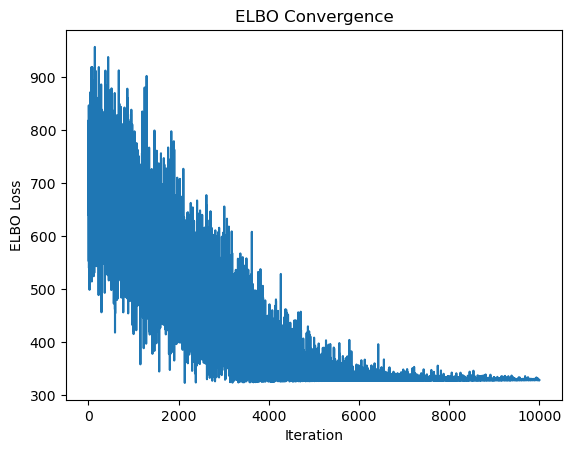

In [25]:
# Define the guide (variational posterior)
def guide(data):
    # Variational parameters for the intercept
    mean_q = pyro.param("mean_q", torch.tensor(0.0, device=device))
    scale_q = pyro.param("scale_q", torch.tensor(1.0, device=device), constraint=dist.constraints.positive)
    
    pyro.sample("intercept", dist.Normal(mean_q, scale_q))

# Data: 900 thumbs up, 100 thumbs down, and make sure its in the right place
data = torch.cat((torch.ones(900), torch.zeros(100))).to(device)

# Set up the optimizer and inference algorithm
optimizer = Adam({"lr": torch.tensor(0.001, device=device)})  # Learning rate
svi = SVI(logistic_model, guide, optimizer, loss=Trace_ELBO())

# Perform optimization
num_steps = 10000
losses = []
for step in range(num_steps):
    loss = svi.step(data)  # Perform one step of optimization
    losses.append(loss)
    if step % 1000 == 0:
        print(f"Step {step} - Loss: {loss}")

# Inspect learned parameters
mean_q = pyro.param("mean_q").item()
scale_q = pyro.param("scale_q").item()
print(f"Posterior Mean: {mean_q}, Posterior Std: {scale_q}")

# Plot ELBO convergence
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("ELBO Loss")
plt.title("ELBO Convergence")
plt.show()

That elbow plot clearly converges, so it looks like the optimizer worked well. All that's left is seeing if the estimate we got for the posterior probability of the intercept is accurate. To do that, we'll need to transform our log odds back into a probability of thumbs up. 

In [26]:
import math

# Convert posterior mean (log-odds) to probability
posterior_mean = pyro.param("mean_q").item()

# Probability from logistic function
posterior_probability = 1 / (1 + math.exp(-posterior_mean))

print(posterior_probability)

0.8993285293702843


A perfect estimate!